# Experimenting with chromosome varying effects

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import product
from math import ceil
from pathlib import Path
from time import time

import aesara
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc as pm
import pymc.sampling_jax
import seaborn as sns
from matplotlib.lines import Line2D

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.10/site-packages/pymc/sampling_jax.py:36: UserWarning: This module is experimental.


In [3]:
from speclet.analysis.arviz_analysis import describe_mcmc, extract_coords_param_names
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel
from speclet.data_processing.common import head_tail
from speclet.io import DataFile, data_path
from speclet.loggers import set_console_handler_level
from speclet.managers.data_managers import CrisprScreenDataManager, broad_only
from speclet.plot import set_speclet_theme
from speclet.project_configuration import arviz_config

In [4]:
# Logging.
set_console_handler_level("DEBUG")
aesara.config.exception_verbosity = "high"

# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_speclet_theme()
%config InlineBackend.figure_format = "retina"

# Constants
SEED = 847
np.random.seed(SEED)
arviz_config()

## Data

In [5]:
crispr_data_manager = CrisprScreenDataManager(
    DataFile.DEPMAP_CRC_SUBSAMPLE, transformations=[broad_only]
)
crc_data = crispr_data_manager.get_data()

In [6]:
for col in ["sgrna", "hugo_symbol", "depmap_id"]:
    print(f"'{col}': {crc_data[col].nunique()}")

'sgrna': 162
'hugo_symbol': 103
'depmap_id': 8


## Modeling

In [7]:
from speclet.bayesian_models.lineage_hierarchical_nb import LineageHierNegBinomModel

In [8]:
crc_model = LineageHierNegBinomModel(
    lineage="colorectal", reduce_deterministic_vars=False
)
valid_crc_data = crc_model.data_processing_pipeline(crc_data.copy())
model_crc_data = crc_model.make_data_structure(valid_crc_data.copy())

[INFO] 2022-08-07 17:37:07 [(lineage_hierarchical_nb.py:data_processing_pipeline:318] Processing data for modeling.
[INFO] 2022-08-07 17:37:07 [(lineage_hierarchical_nb.py:data_processing_pipeline:319] LFC limits: (-5.0, 5.0)
[WARNING] 2022-08-07 17:37:07 [(lineage_hierarchical_nb.py:data_processing_pipeline:377] number of data points dropped: 0
[INFO] 2022-08-07 17:37:07 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:588] number of genes mutated in all cells lines: 1
[DEBUG] 2022-08-07 17:37:07 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:591] Genes always mutated: APC
[DEBUG] 2022-08-07 17:37:07 [(cancer_gene_mutation_matrix.py:_trim_cancer_genes:68] all_mut: {}
[INFO] 2022-08-07 17:37:07 [(cancer_gene_mutation_matrix.py:_trim_cancer_genes:77] Dropping 2 cancer genes.
[DEBUG] 2022-08-07 17:37:07 [(cancer_gene_mutation_matrix.py:_trim_cancer_genes:79] Dropped cancer genes: ['APC', 'MDM2']


In [9]:
model_crc_data.coords["cancer_gene"]

['FBXW7', 'KRAS', 'PIK3CA']

[INFO] 2022-08-07 17:37:08 [(lineage_hierarchical_nb.py:data_processing_pipeline:318] Processing data for modeling.
[INFO] 2022-08-07 17:37:08 [(lineage_hierarchical_nb.py:data_processing_pipeline:319] LFC limits: (-5.0, 5.0)
[WARNING] 2022-08-07 17:37:09 [(lineage_hierarchical_nb.py:data_processing_pipeline:377] number of data points dropped: 0
[INFO] 2022-08-07 17:37:09 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:588] number of genes mutated in all cells lines: 1
[DEBUG] 2022-08-07 17:37:09 [(lineage_hierarchical_nb.py:target_gene_is_mutated_vector:591] Genes always mutated: APC
[DEBUG] 2022-08-07 17:37:09 [(cancer_gene_mutation_matrix.py:_trim_cancer_genes:68] all_mut: {}
[INFO] 2022-08-07 17:37:09 [(cancer_gene_mutation_matrix.py:_trim_cancer_genes:77] Dropping 2 cancer genes.
[DEBUG] 2022-08-07 17:37:09 [(cancer_gene_mutation_matrix.py:_trim_cancer_genes:79] Dropped cancer genes: ['APC', 'MDM2']
[INFO] 2022-08-07 17:37:09 [(lineage_hierarchical_nb.py:_pre_model_mess

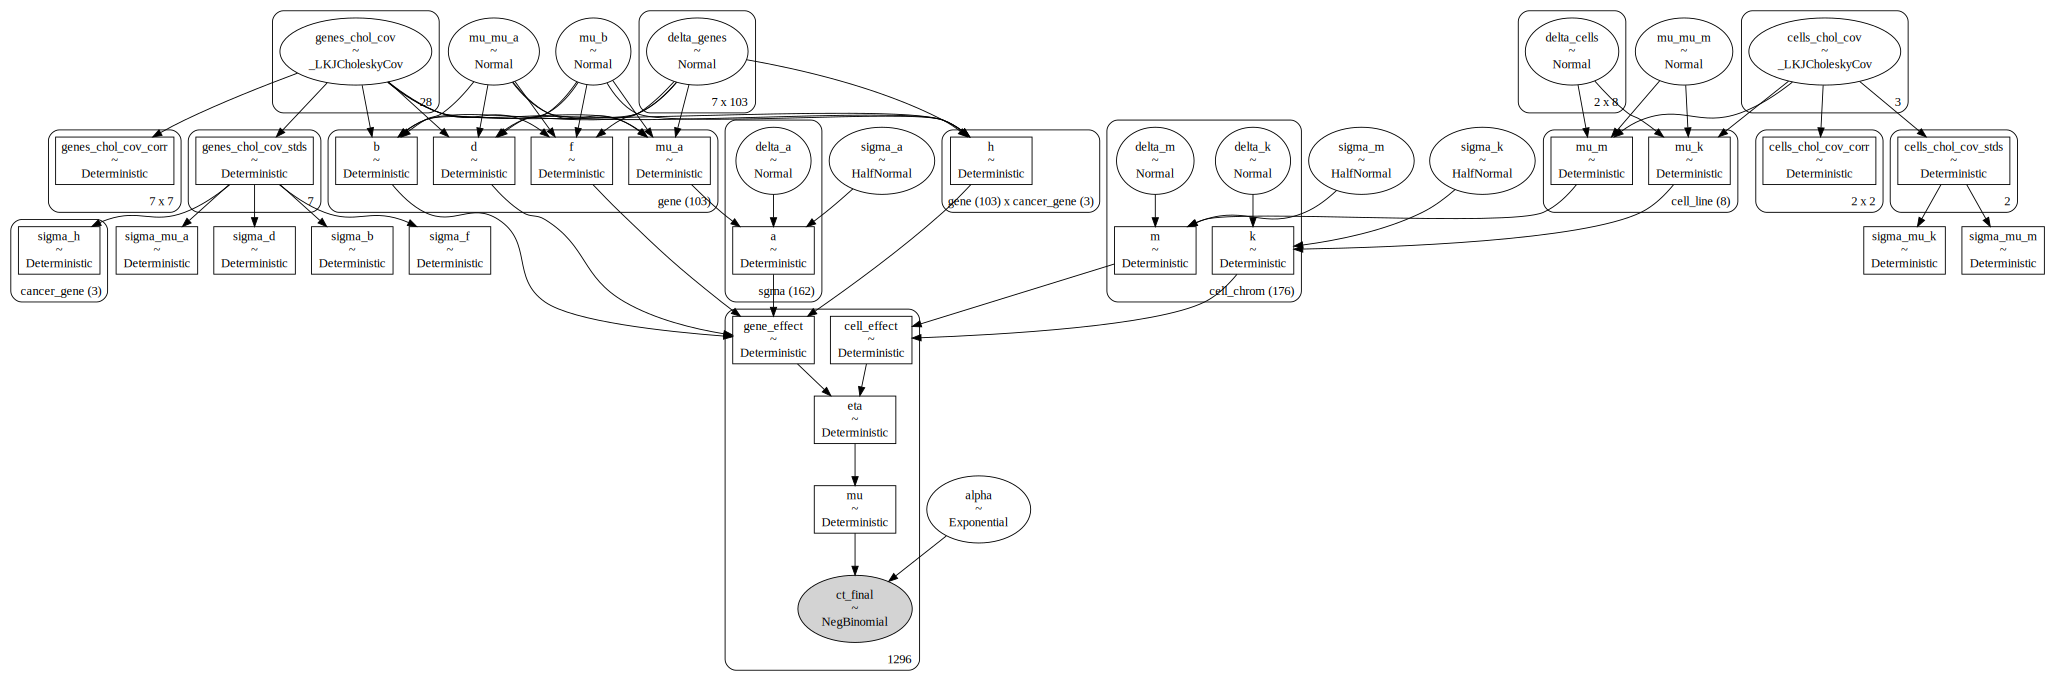

In [10]:
crc_pymc_model = crc_model.pymc_model(crispr_data_manager.data.copy())
pm.model_to_graphviz(crc_pymc_model)

In [11]:
with crc_pymc_model:
    pm_prior_pred = pm.sample_prior_predictive(
        var_names=["eta", "ct_final", "mu_a", "gene_effect"], random_seed=SEED
    )

print("prior predictive distribution")
pm_pred_draws = pm_prior_pred.prior_predictive["ct_final"].values.squeeze()
for q in [0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 1]:
    res = np.quantile(pm_pred_draws, q=q)
    print(f"  {int(q*100)}%: {int(res):0,d}")

print("")
obs = valid_crc_data["counts_final"].astype(int)
print(f"final counts\n  min: {np.min(obs):,d},  max: {np.max(obs):,d}")

obs = valid_crc_data["counts_initial_adj"].astype(int)
print(f"initial counts\n  min: {np.min(obs):,d},  max: {np.max(obs):,d}")

prior predictive distribution
  0%: 0
  1%: 0
  10%: 9
  20%: 50
  30%: 112
  40%: 195
  50%: 313
  60%: 486
  70%: 762
  80%: 1,274
  90%: 2,594
  99%: 16,315
  100%: 51,505,825

final counts
  min: 0,  max: 9,819
initial counts
  min: 57,  max: 4,741


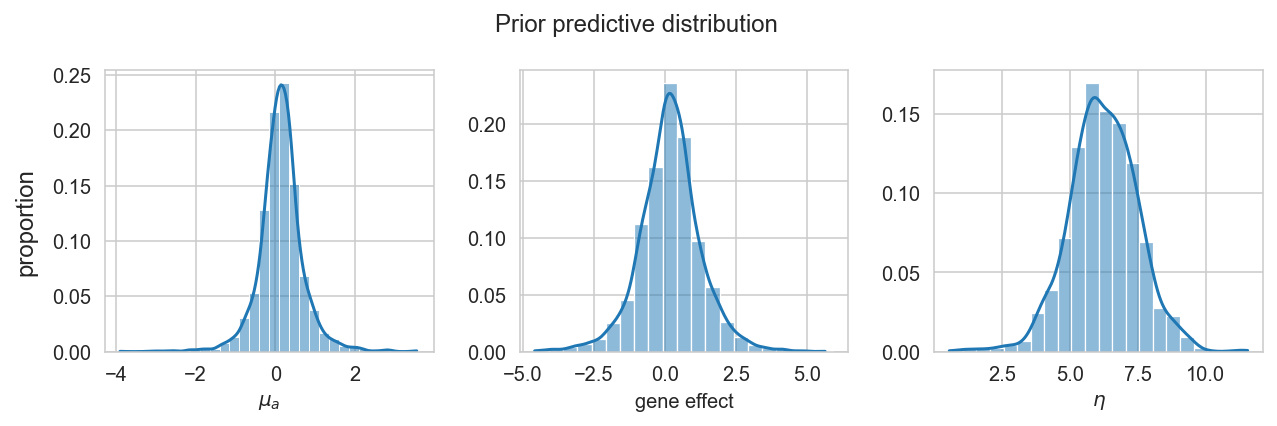

In [12]:
eta_prior = np.random.choice(pm_prior_pred.prior["eta"].values.flatten(), 2000)
ge_prior = np.random.choice(pm_prior_pred.prior["gene_effect"].values.flatten(), 4000)
mu_prior = np.random.choice(pm_prior_pred.prior["mu_a"].values.flatten(), 4000)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3))
sns.histplot(mu_prior, kde=True, ax=axes[0], binwidth=0.25, stat="proportion")
sns.histplot(ge_prior, kde=True, ax=axes[1], binwidth=0.5, stat="proportion")
sns.histplot(eta_prior, kde=True, ax=axes[2], binwidth=0.5, stat="proportion")
axes[0].set_xlabel(r"$\mu_a$")
axes[1].set_xlabel(r"gene effect")
axes[2].set_xlabel(r"$\eta$")

for ax in axes.flatten():
    ax.set_ylabel(None)
    ax.set_title(None)

fig.supylabel("proportion")
fig.suptitle("Prior predictive distribution")
fig.tight_layout()
plt.show()

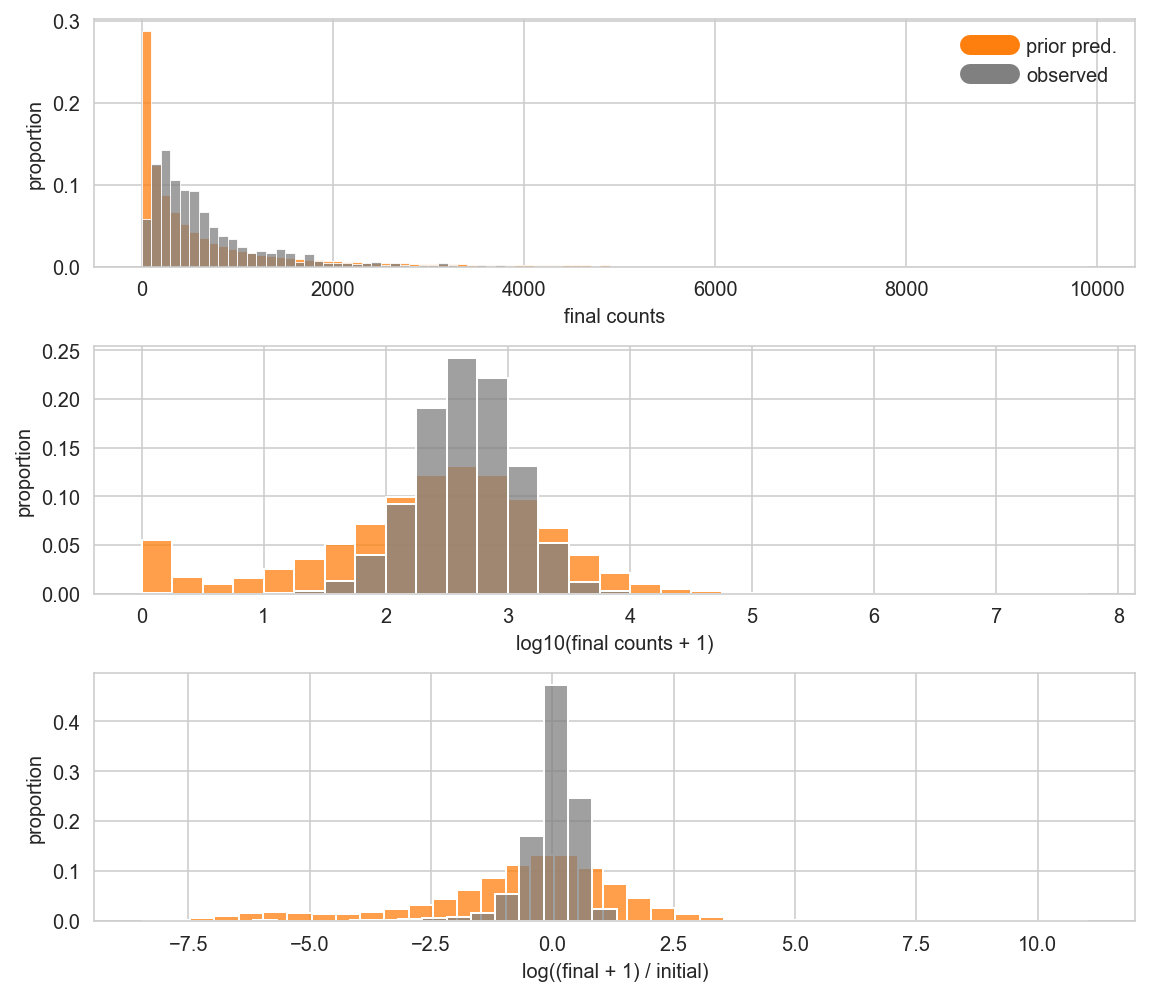

In [13]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 7))

stat = "proportion"

obs_max = crc_data["counts_final"].max()
truncated_prior_preds = [x for x in pm_pred_draws.flatten() if x <= obs_max]

prior_pred_pal = {"prior pred.": "tab:orange", "observed": "gray"}

# Untransformed
bw: float = 100
sns.histplot(
    x=truncated_prior_preds,
    ax=axes[0],
    binwidth=bw,
    stat=stat,
    color=prior_pred_pal["prior pred."],
)
sns.histplot(
    x=valid_crc_data["counts_final"],
    ax=axes[0],
    binwidth=bw,
    stat=stat,
    color=prior_pred_pal["observed"],
)
# Log10 transformed
bw = 0.25
sns.histplot(
    x=np.log10(pm_pred_draws.flatten() + 1),
    ax=axes[1],
    binwidth=bw,
    stat=stat,
    color=prior_pred_pal["prior pred."],
)
sns.histplot(
    x=np.log10(valid_crc_data["counts_final"] + 1),
    ax=axes[1],
    binwidth=bw,
    stat=stat,
    color=prior_pred_pal["observed"],
)
# Log-fold change
pp_lfc = np.log(
    (pm_pred_draws + 1) / (valid_crc_data["counts_initial_adj"].values[None, :])
)
obs_lfc = np.log(
    (valid_crc_data["counts_final"] + 1) / valid_crc_data["counts_initial_adj"]
)
bw = 0.5
sns.histplot(
    x=pp_lfc.flatten(),
    ax=axes[2],
    binwidth=bw,
    stat=stat,
    color=prior_pred_pal["prior pred."],
)
sns.histplot(
    x=obs_lfc,
    ax=axes[2],
    binwidth=bw,
    stat=stat,
    color=prior_pred_pal["observed"],
)


axes[0].set_xlabel("final counts")
axes[1].set_xlabel("log10(final counts + 1)")
axes[2].set_xlabel("log((final + 1) / initial)")

prior_pred_leg_handles = [
    Line2D([0], [0], linewidth=10, color=v, label=k) for k, v in prior_pred_pal.items()
]
axes[0].legend(handles=prior_pred_leg_handles, loc="upper right", frameon=False)

for ax in axes.flatten():
    ax.set_ylabel(stat)

plt.tight_layout()
plt.show()

## Sampling

In [14]:
with crc_pymc_model:
    trace = pymc.sampling_jax.sample_numpyro_nuts(
        draws=500,
        tune=1000,
        target_accept=0.98,
        random_seed=SEED,
        idata_kwargs={"log_likelihood": False},
        nuts_kwargs={"step_size": 0.1, "max_tree_depth": 10}
        # discard_tuned_samples=False,
    )
    pm.sample_posterior_predictive(trace, extend_inferencedata=True, random_seed=SEED)

Compiling...
Compilation time =  0:00:16.629184
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling time =  0:03:42.611335
Transforming variables...
Transformation time =  0:00:06.008289


## Posterior analysis

date created: 2022-08-07 21:41
sampled 4 chains with (unknown) tuning steps and 500 draws
num. divergences: 0, 0, 0, 0
percent divergences: 0.0, 0.0, 0.0, 0.0
BFMI: 0.831, 0.825, 0.906, 0.969
avg. step size: 0.034, 0.032, 0.046, 0.018
avg. accept prob.: 0.957, 0.946, 0.916, 0.983
avg. tree depth: 7.0, 7.0, 7.0, 8.0


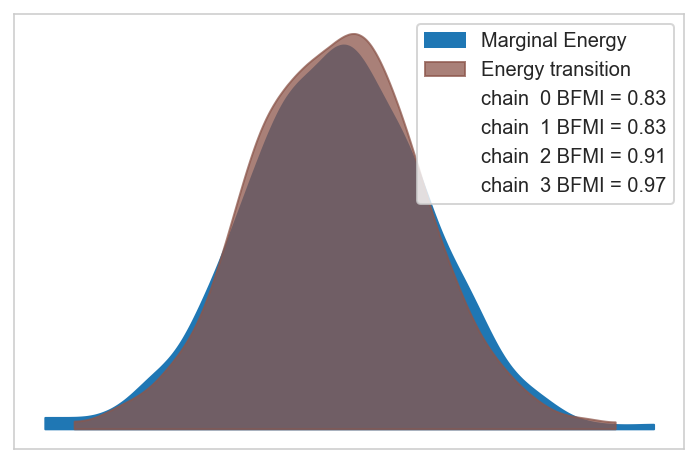

In [15]:
describe_mcmc(trace);

In [16]:
stat_cats = ["energy", "step_size", "n_steps", "acceptance_rate", "tree_depth"]
trace.sample_stats.get(stat_cats).to_dataframe().groupby("chain").mean().round(3)

energy  step_size  n_steps  acceptance_rate  tree_depth
chain                                                            
0      10889.138      0.034    127.0            0.957         7.0
1      10890.874      0.032    127.0            0.946         7.0
2      10887.237      0.046    127.0            0.916         7.0
3      10892.429      0.018    255.0            0.983         8.0

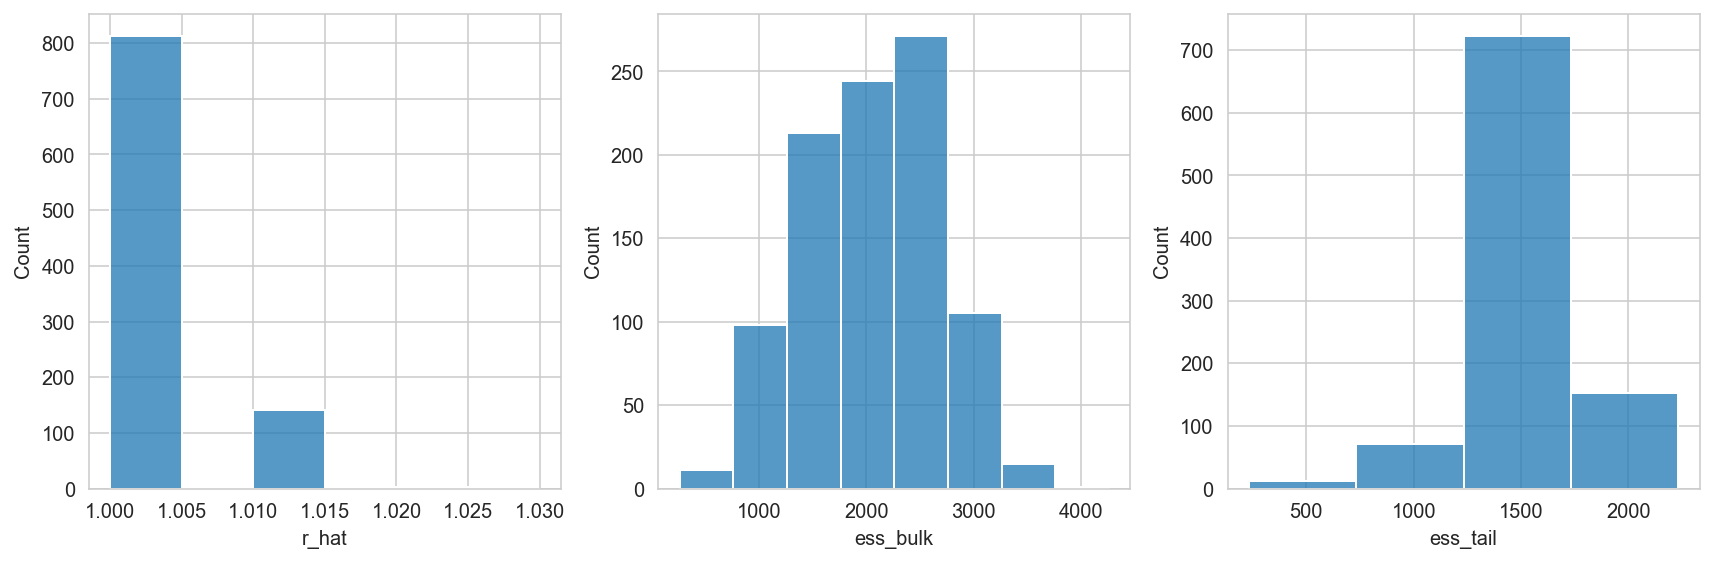

In [17]:
post_summary = az.summary(
    trace, var_names=crc_model.vars_regex() + ["~^h$"], filter_vars="regex"
)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax = axes[0]
sns.histplot(data=post_summary, x="r_hat", binwidth=0.005, ax=ax)

ax = axes[1]
sns.histplot(data=post_summary, x="ess_bulk", binwidth=500, ax=ax)

ax = axes[2]
sns.histplot(data=post_summary, x="ess_tail", binwidth=500, ax=ax)

fig.tight_layout()
plt.show()

In [18]:
post_summary.sort_values("ess_bulk").head(5)

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
sigma_b     0.040  0.023     0.001      0.070      0.001    0.001     262.0   
sigma_d     0.189  0.135     0.003      0.372      0.007    0.005     340.0   
sigma_f     0.220  0.082     0.096      0.368      0.004    0.003     462.0   
sigma_mu_k  0.042  0.026     0.000      0.074      0.001    0.001     481.0   
b[MDM2]    -0.046  0.053    -0.130      0.026      0.002    0.002     521.0   

            ess_tail  r_hat  
sigma_b        697.0   1.03  
sigma_d        603.0   1.01  
sigma_f        233.0   1.01  
sigma_mu_k     501.0   1.00  
b[MDM2]       1357.0   1.02

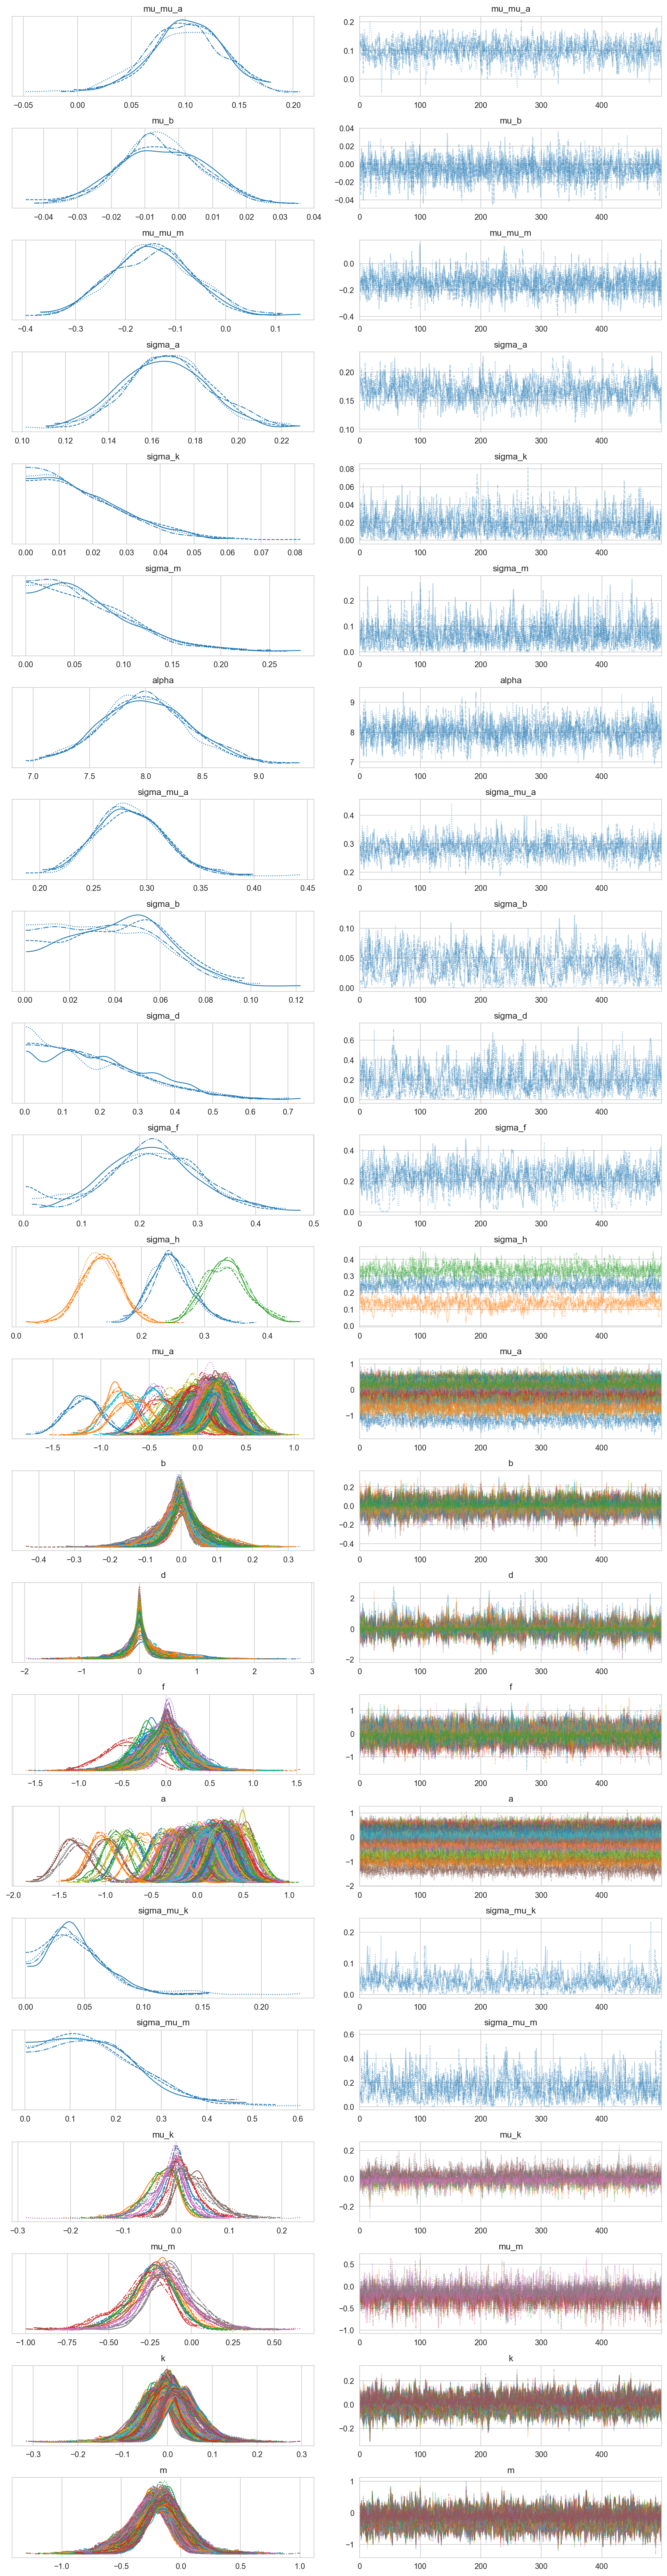

In [19]:
with az.rc_context(rc={"plot.max_subplots": 50}):
    az.plot_trace(
        trace, var_names=crc_model.vars_regex() + ["~^h$"], filter_vars="regex"
    )
    plt.tight_layout()
    plt.show()

In [20]:
chrom_map = (
    valid_crc_data[["depmap_id", "sgrna_target_chr", "cell_chrom"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

chromosome_post = (
    az.summary(trace, var_names=["k", "m"], kind="stats")
    .pipe(extract_coords_param_names, names=["cell_chrom"])
    .assign(var_name=lambda d: [x[0] for x in d.index.values])
    .merge(chrom_map, on="cell_chrom")
)
chromosome_post.head()

mean     sd  hdi_5.5%  hdi_94.5%     cell_chrom var_name   depmap_id  \
0 -0.000  0.036    -0.060      0.056  ACH-000253__1        k  ACH-000253   
1 -0.239  0.170    -0.531      0.008  ACH-000253__1        m  ACH-000253   
2  0.002  0.037    -0.053      0.065  ACH-000253__2        k  ACH-000253   
3 -0.243  0.167    -0.529      0.005  ACH-000253__2        m  ACH-000253   
4  0.003  0.037    -0.052      0.063  ACH-000253__3        k  ACH-000253   

  sgrna_target_chr  
0                1  
1                1  
2                2  
3                2  
4                3

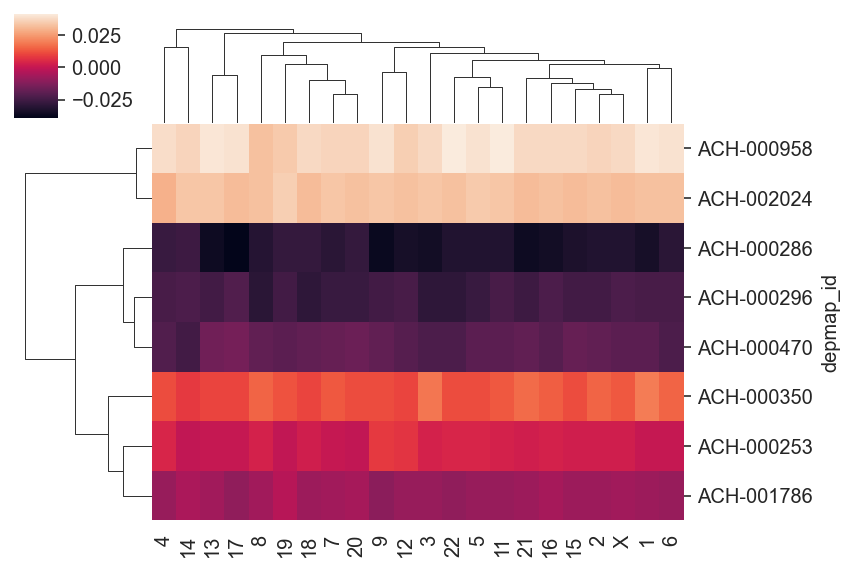

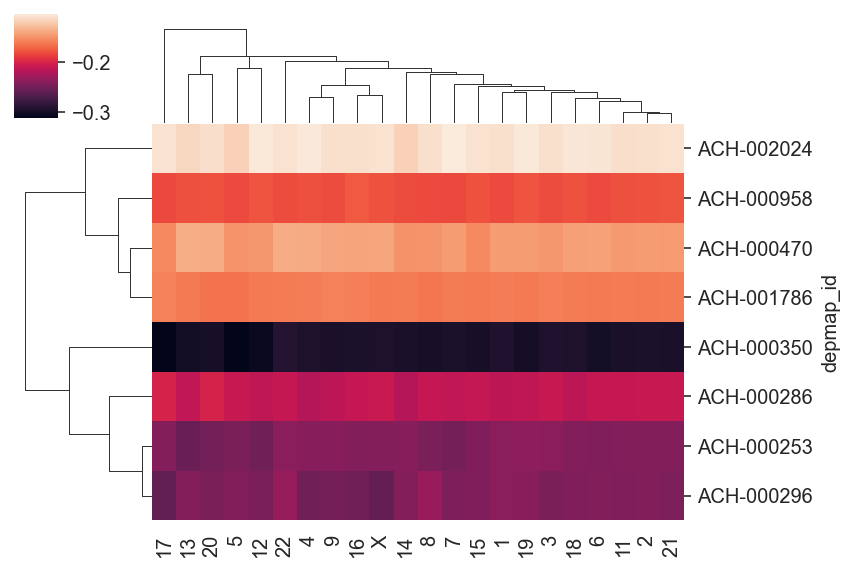

In [21]:
for v, data_v in chromosome_post.groupby("var_name"):
    df = (
        data_v.copy()
        .reset_index(drop=True)
        .pivot_wider(
            index="depmap_id", names_from="sgrna_target_chr", values_from="mean"
        )
        .set_index("depmap_id")
    )
    sns.clustermap(df, figsize=(6, 4))
    plt.show()

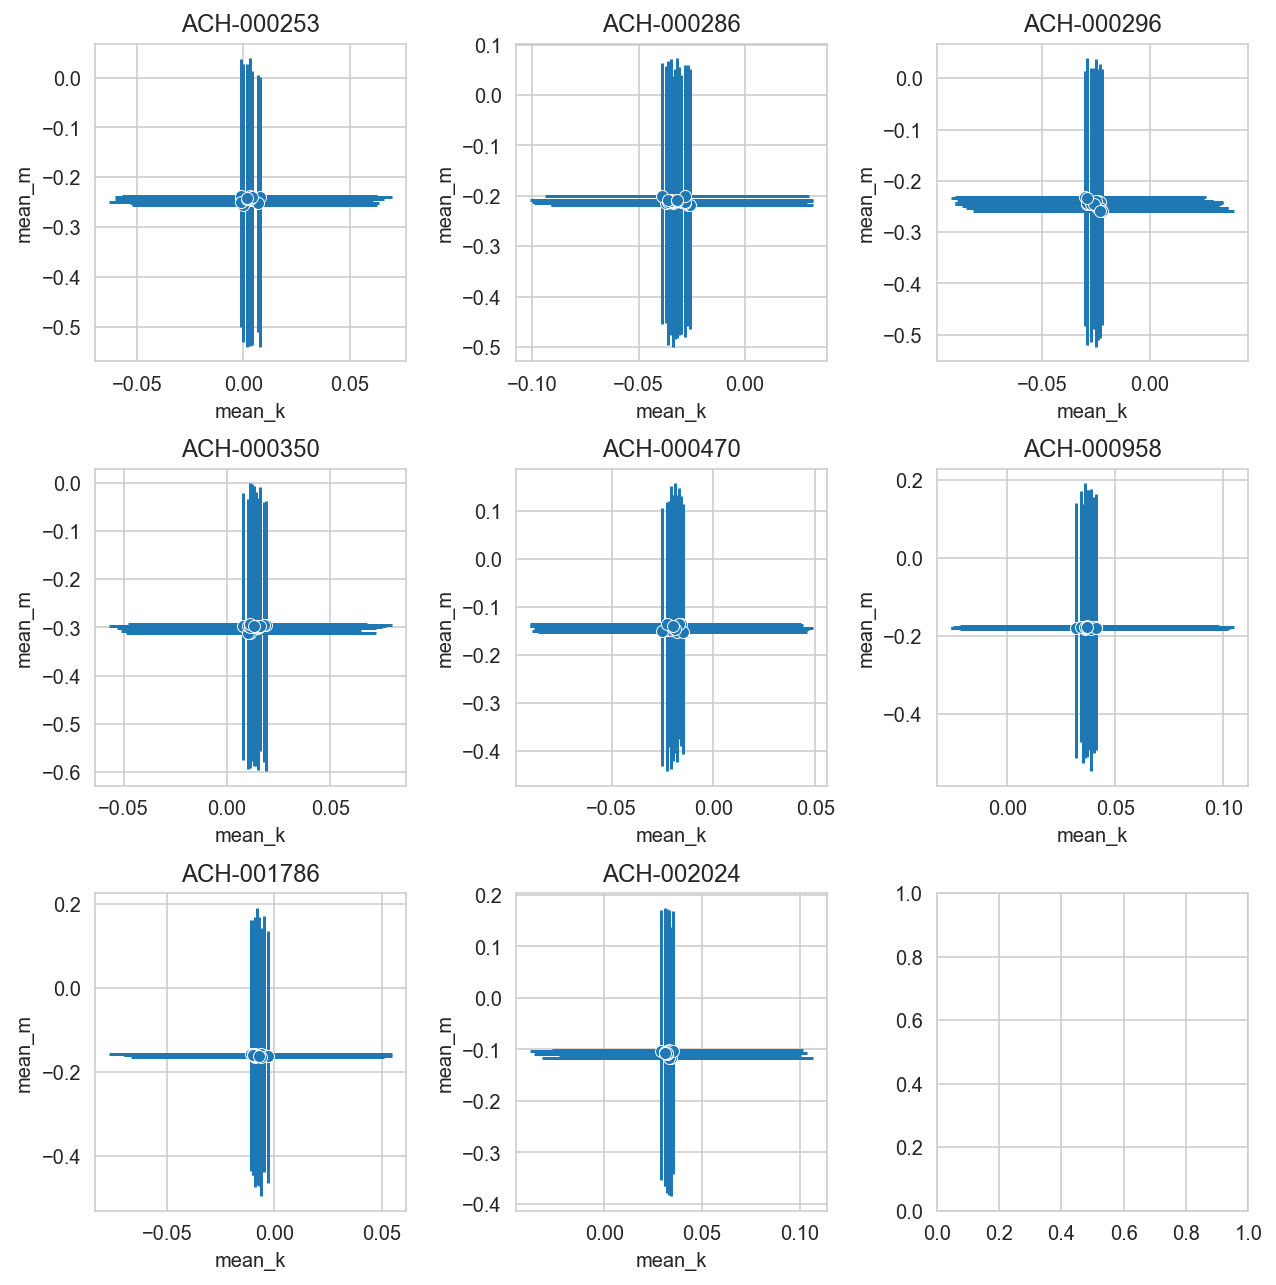

In [43]:
ncells = chromosome_post["depmap_id"].nunique()
ncols = 3
nrows = ceil(ncells / 3)
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(9, nrows * 3))
for ax, (cell, data_c) in zip(axes.flatten(), chromosome_post.groupby("depmap_id")):
    plot_df = data_c.pivot_wider(
        index="sgrna_target_chr",
        names_from="var_name",
        values_from=["mean", "hdi_5.5%", "hdi_94.5%"],
    )
    ax.vlines(
        x=plot_df["mean_k"],
        ymin=plot_df["hdi_5.5%_m"],
        ymax=plot_df["hdi_94.5%_m"],
        zorder=5,
    )
    ax.hlines(
        y=plot_df["mean_m"],
        xmin=plot_df["hdi_5.5%_k"],
        xmax=plot_df["hdi_94.5%_k"],
        zorder=5,
    )
    sns.scatterplot(data=plot_df, x="mean_k", y="mean_m", ax=ax, zorder=10)
    ax.set_title(cell)

fig.tight_layout()
plt.show()

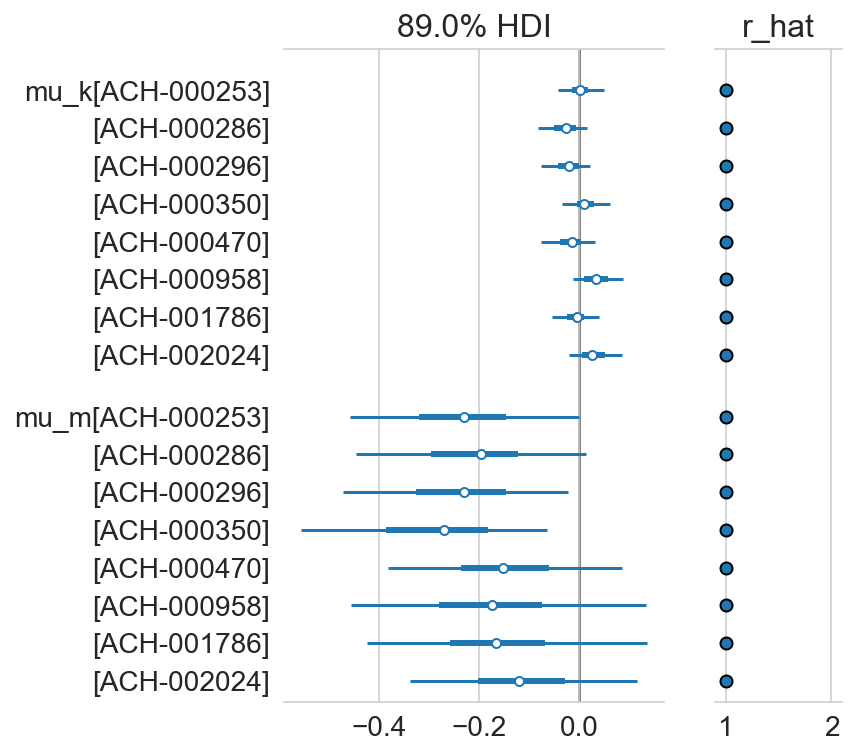

In [22]:
axes = az.plot_forest(
    trace, var_names=["mu_k", "mu_m"], combined=True, r_hat=True, figsize=(5, 6)
)
line = axes[0].axvline(color="gray")
line.set_zorder(0)
plt.show()

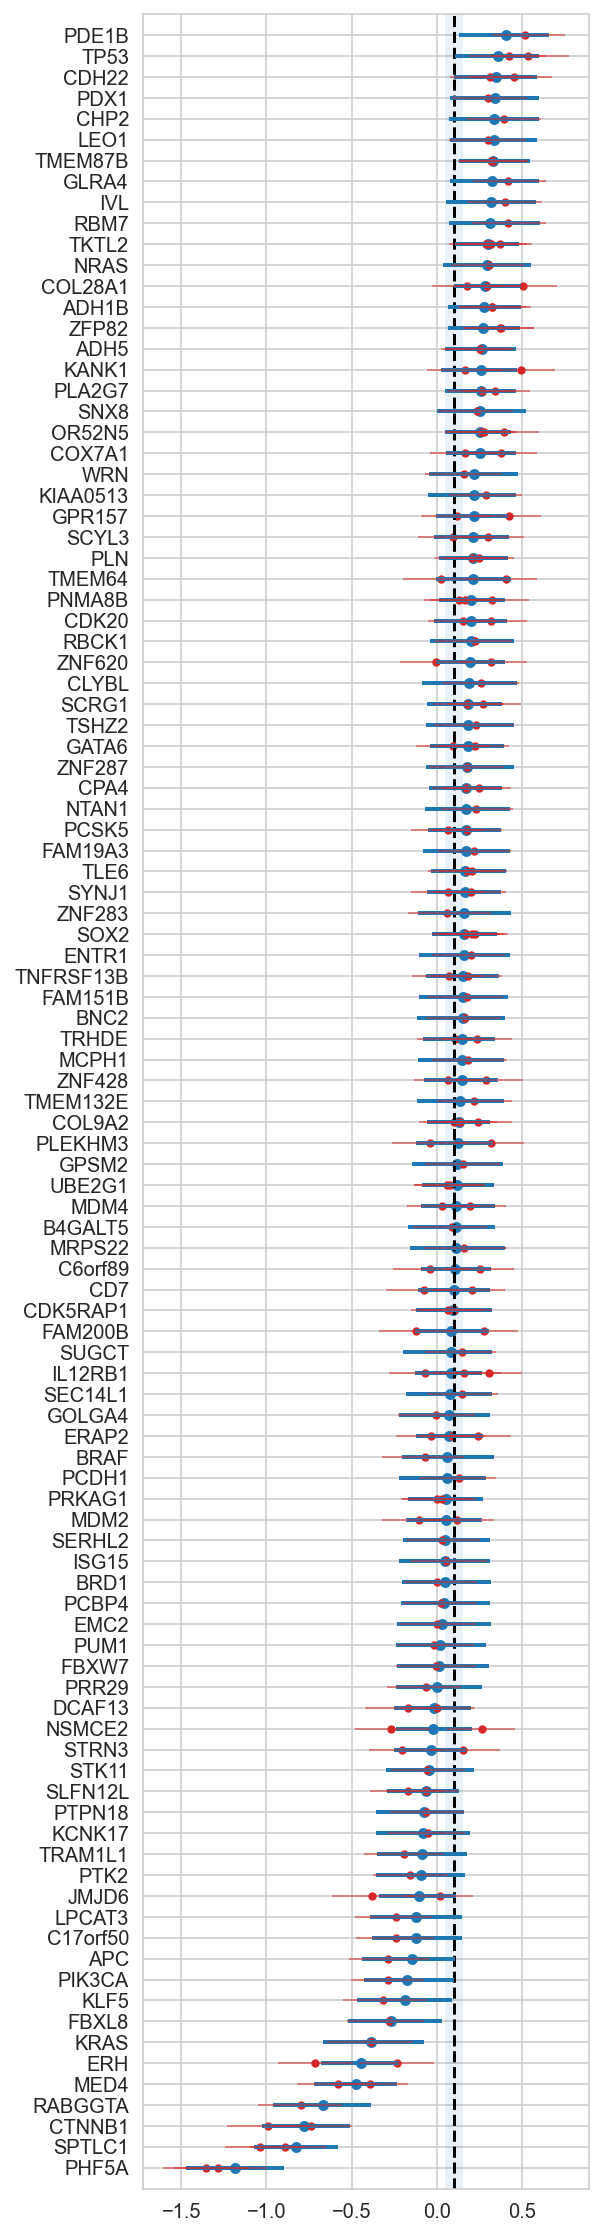

In [23]:
gene_order = (
    az.summary(trace, var_names=["mu_a"], kind="stats")
    .pipe(extract_coords_param_names, names=["hugo_symbol"])
    .sort_values("mean")["hugo_symbol"]
    .tolist()
)

sgrna_to_gene_map = (
    crc_data[["hugo_symbol", "sgrna"]].drop_duplicates().reset_index(drop=True)
)
a_post = (
    az.summary(trace, var_names=["a"], kind="stats")
    .pipe(extract_coords_param_names, names=["sgrna"])
    .reset_index(drop=True)
    .merge(sgrna_to_gene_map, on="sgrna", validate="one_to_one")
)
mu_a_post = (
    az.summary(trace, var_names=["mu_a"], kind="stats")
    .pipe(extract_coords_param_names, names=["hugo_symbol"])
    .reset_index(drop=True)
)

a_post["hugo_symbol"] = pd.Categorical(
    a_post["hugo_symbol"], categories=gene_order, ordered=True
)
a_post = a_post.sort_values("hugo_symbol").reset_index(drop=True)
mu_a_post["hugo_symbol"] = pd.Categorical(
    mu_a_post["hugo_symbol"], categories=gene_order, ordered=True
)
mu_a_post = mu_a_post.sort_values("hugo_symbol").reset_index(drop=True)

mu_mu_a_post = az.summary(trace, var_names=["mu_mu_a"], kind="stats")
assert len(mu_mu_a_post) == 1
mu_mu_a_avg = mu_mu_a_post["mean"][0]
mu_mu_a_hdi = (mu_mu_a_post["hdi_5.5%"][0], mu_mu_a_post["hdi_94.5%"][0])

fig, ax = plt.subplots(figsize=(4, 20))

# Population average and HDI
plt.fill_between(x=mu_mu_a_hdi, y1=-1, y2=len(mu_a_post), alpha=0.1)
plt.axvline(mu_mu_a_avg, color="k", linestyle="--")

# Gene estimates.
plt.hlines(
    y=mu_a_post["hugo_symbol"],
    xmin=mu_a_post["hdi_5.5%"],
    xmax=mu_a_post["hdi_94.5%"],
    color="tab:blue",
    linewidth=2,
)
plt.scatter(x=mu_a_post["mean"], y=mu_a_post["hugo_symbol"], s=20, c="tab:blue")

# sgRNA estimates.
plt.hlines(
    y=a_post["hugo_symbol"],
    xmin=a_post["hdi_5.5%"],
    xmax=a_post["hdi_94.5%"],
    color="tab:red",
    linewidth=1,
    alpha=0.5,
)
plt.scatter(x=a_post["mean"], y=a_post["hugo_symbol"], s=10, c="tab:red")

plt.ylim(-1, len(mu_a_post))
plt.show()

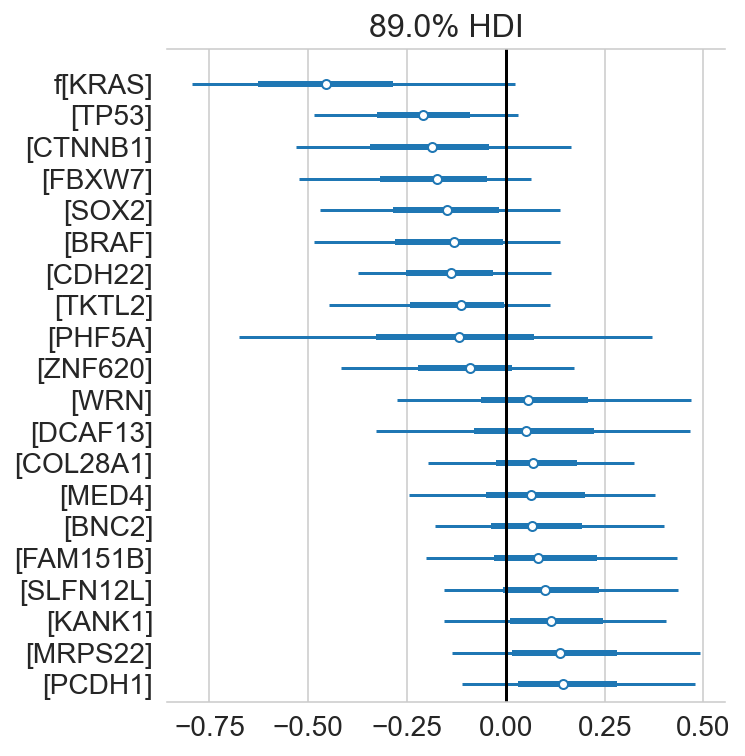

In [24]:
top_mut_effect_genes = (
    az.summary(trace, var_names=["f"])
    .sort_values("mean")
    .pipe(head_tail)
    .pipe(extract_coords_param_names, "hugo_symbol")["hugo_symbol"]
    .tolist()
)
ax = az.plot_forest(
    trace,
    var_names=["f"],
    coords={"gene": top_mut_effect_genes},
    combined=True,
    figsize=(5, 6),
)
ax[0].axvline(0, color="k")
plt.show()

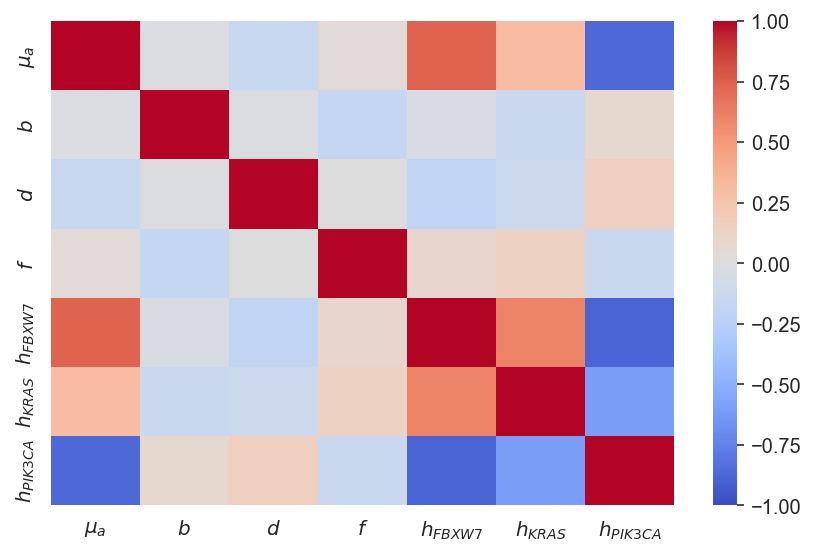

In [25]:
gene_vars = ["$\mu_a$", "$b$", "$d$", "$f$"]
gene_vars += ["$h_{" + g + "}$" for g in trace.posterior.coords["cancer_gene"].values]
gene_corr_post = (
    az.summary(trace, var_names=["genes_chol_cov_corr"], kind="stats")
    .pipe(extract_coords_param_names, names=["d0", "d1"])
    .astype({"d0": int, "d1": int})
    .assign(
        p0=lambda d: [gene_vars[i] for i in d["d0"]],
        p1=lambda d: [gene_vars[i] for i in d["d1"]],
    )
)

plot_df = gene_corr_post.pivot_wider(
    "p0", names_from="p1", values_from="mean"
).set_index("p0")
ax = sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.tight_layout()
plt.show()

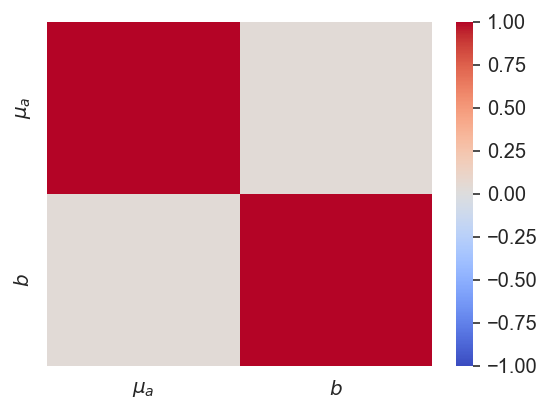

In [26]:
cells_vars = ["$k$", "$m$"]
cells_corr_post = (
    az.summary(trace, var_names=["cells_chol_cov_corr"], kind="stats")
    .pipe(extract_coords_param_names, names=["d0", "d1"])
    .astype({"d0": int, "d1": int})
    .assign(
        p0=lambda d: [gene_vars[i] for i in d["d0"]],
        p1=lambda d: [gene_vars[i] for i in d["d1"]],
    )
)

plot_df = cells_corr_post.pivot_wider(
    "p0", names_from="p1", values_from="mean"
).set_index("p0")
_, ax = plt.subplots(figsize=(4, 3))
ax = sns.heatmap(plot_df, cmap="coolwarm", vmin=-1, vmax=1)
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.tight_layout()
plt.show()

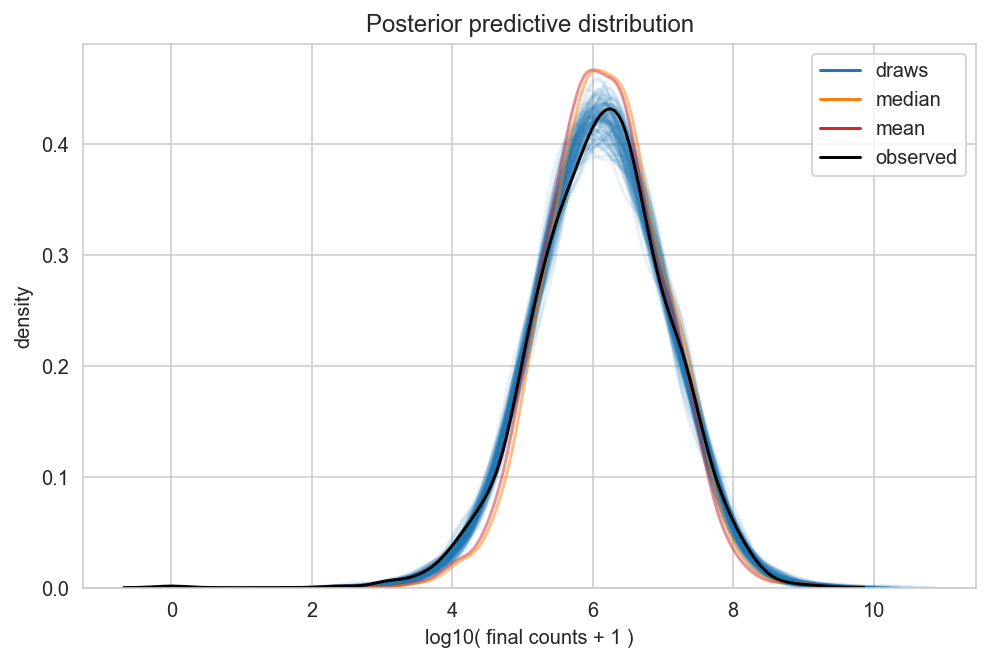

In [27]:
N = 100

pp_dist = trace.posterior_predictive["ct_final"]
n_chains, n_draws, n_samples = pp_dist.shape
draws_idx = np.random.choice(np.arange(n_draws), N // n_chains, replace=False)

fig, ax = plt.subplots(figsize=(8, 5))

ppc_pal = {
    "draws": "tab:blue",
    "median": "tab:orange",
    "mean": "tab:red",
    "observed": "black",
}

# Example draws.
for c, d in product(range(n_chains), draws_idx):
    values = np.log(pp_dist[c, d, :].values + 1)
    sns.kdeplot(values, color=ppc_pal["draws"], alpha=0.1, ax=ax)

# Average distributions.
pp_dist_mean = np.log(pp_dist.median(axis=(0, 1)) + 1)
pp_dist_mid = np.log(pp_dist.mean(axis=(0, 1)) + 1)
sns.kdeplot(pp_dist_mean, color=ppc_pal["mean"], ax=ax, alpha=0.5)
sns.kdeplot(pp_dist_mid, color=ppc_pal["median"], ax=ax, alpha=0.5)

# Observed distribution.
sns.kdeplot(
    np.log(trace.observed_data["ct_final"] + 1), ax=ax, color=ppc_pal["observed"]
)

ppc_leg_handles: list[Line2D] = []
for lbl, color in ppc_pal.items():
    ppc_leg_handles.append(Line2D([0], [0], color=color, label=lbl))

plt.legend(handles=ppc_leg_handles, loc="best")


ax.set_xlabel("log10( final counts + 1 )")
ax.set_ylabel("density")
ax.set_title("Posterior predictive distribution")
plt.show()

---

In [28]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 7.53 minutes


In [29]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-08-07

Python implementation: CPython
Python version       : 3.10.5
IPython version      : 8.4.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: jhcookmac.harvardsecure.wireless.med.harvard.edu

Git branch: varying-chromosome

pymc      : 4.1.3
matplotlib: 3.5.2
arviz     : 0.12.1
numpy     : 1.23.1
pandas    : 1.4.3
seaborn   : 0.11.2
plotnine  : 0.0.0
aesara    : 2.7.7

